# Jessie Xie(21918545)
# Random forests

> Note: use the X_train_afterFilterFeatures, X_val_afterFilterFeatures, X_test_afterFilterFeatures produced by "01-DecisionTrees(main).ipynb" and y_train, y_val, y_test from github to keep consistent <br>
> The purpose of the notebook is to try **Random Forests** and use **SHAP (SHapley Additive exPlanations)** to explain Random Forests. <br>

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go


from sklearn.metrics import accuracy_score,recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV


from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek

import shap

In [2]:
# Read in the csv file
X_train = pd.read_csv('X_train_afterFilterFeatures.csv')
y_train = pd.read_csv('y_train.csv')
X_val = pd.read_csv('X_val_afterFilterFeatures.csv')
y_val = pd.read_csv('y_val.csv')
X_test = pd.read_csv('X_test_afterFilterFeatures.csv')
y_test = pd.read_csv('y_test.csv')
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_val shape", X_val.shape)
print("y_val shape", y_val.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (152, 76)
y_train shape (152, 1)
X_val shape (39, 76)
y_val shape (39, 1)
X_test shape (48, 76)
y_test shape (48, 1)


In [3]:
# view the distribution of OverallPoF of the training set and test set as the baseline
print("The percentage of pass (training set): ", sum(y_train['OverallPoF']==0)/len(y_train["OverallPoF"]))
print("The percentage of fail (training set):", sum(y_train['OverallPoF']==1)/len(y_train["OverallPoF"]))
print("The percentage of pass (val set): ", sum(y_val['OverallPoF']==0)/len(y_val["OverallPoF"]))
print("The percentage of fail (val set):", sum(y_val['OverallPoF']==1)/len(y_val["OverallPoF"]))
print("The percentage of pass (test set): ", sum(y_test['OverallPoF']==0)/len(y_test["OverallPoF"]))
print("The percentage of fail (test set):", sum(y_test['OverallPoF']==1)/len(y_test["OverallPoF"]))

The percentage of pass (training set):  0.8552631578947368
The percentage of fail (training set): 0.14473684210526316
The percentage of pass (val set):  0.7692307692307693
The percentage of fail (val set): 0.23076923076923078
The percentage of pass (test set):  0.8541666666666666
The percentage of fail (test set): 0.14583333333333334


# 1. Handling imbalenced dataset


In [4]:
def dataset_barplot(y_data, title):
    pass_ = sum(y_data['OverallPoF']==0)
    fail_ = sum(y_data['OverallPoF']==1)
    PoF = ['Pass', "Fail"]
    count = [pass_, fail_]
    data = [go.Bar(
    x = PoF,
    y = count
    )] 
    fig = go.Figure(data=data)
    fig.update_layout(
        title=title)
    fig.show()
    return fig

## 1.1. NearMiss Under-sampling

In [6]:
nearmiss = NearMiss(sampling_strategy = 'majority', version = 2, n_jobs = -1)
X_nm, y_nm = nearmiss.fit_resample(X_train, y_train)
fig = dataset_barplot(y_nm, 'NearMiss Under-sampling')
fig.write_html('plots/RF/NM_bar.html')
print("The count of pass (NearMiss Under-sampling):", sum(y_nm['OverallPoF']==0))
print("The count of fail (NearMiss Under-sampling):", sum(y_nm['OverallPoF']==1))

The count of pass (NearMiss Under-sampling): 22
The count of fail (NearMiss Under-sampling): 22


## 1.2. SMOTE Over-sampling

In [7]:
smote = SMOTE(sampling_strategy = 'minority', random_state = 12)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
fig = dataset_barplot(y_smote, 'SMOTE Over-sampling')
fig.write_html('plots/RF/SMOTE_OS_bar.html')
print("The count of pass (SMOTE Over-sampling):", sum(y_smote['OverallPoF']==0))
print("The count of fail (SMOTE Over-sampling):", sum(y_smote['OverallPoF']==1))

The count of pass (SMOTE Over-sampling): 130
The count of fail (SMOTE Over-sampling): 130


## 1.3. SMOTEENN

In [8]:
smoteenn = SMOTEENN(sampling_strategy = 'auto', random_state = 12, smote = smote)
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)
fig = dataset_barplot(y_smoteenn, 'SMOTEENN')
fig.write_html('plots/RF/SMOTEENN_bar.html')
print("The count of pass (SMOTEENN):", sum(y_smoteenn['OverallPoF']==0))
print("The count of fail (SMOTEENN):", sum(y_smoteenn['OverallPoF']==1))

The count of pass (SMOTEENN): 84
The count of fail (SMOTEENN): 117


## 1.4. SMOTETomek

In [9]:
smotetomek = SMOTETomek(sampling_strategy = 'auto', random_state = 12,smote = smote)
X_smotetomek, y_smotetomek = smotetomek.fit_resample(X_train, y_train)
fig = dataset_barplot(y_smotetomek, 'SMOTETomek')
fig.write_html('plots/RF/SMOTETomek_bar.html')
print("The count of pass (SMOTETomek):", sum(y_smotetomek['OverallPoF']==0))
print("The count of fail (SMOTETomek):", sum(y_smotetomek['OverallPoF']==1))

The count of pass (SMOTETomek): 129
The count of fail (SMOTETomek): 129


# 2. Random Forests

In [10]:
def rforest_grid_search(X,y,nfolds):
    '''
    Hyperparameter Tuning with GridSearchCV
    '''
    # create a dictionary of all values we want to test
    param_grid = {
        'n_estimators':[10, 50, 100, 150],
        'criterion':['gini','entropy'],
        'max_depth': np.arange(3, 15)}
    # decision tree model
    rforest_model= RandomForestClassifier(random_state=12)
    # use gridsearch to test all values
    rforest_gscv = GridSearchCV(rforest_model, param_grid, cv=nfolds, return_train_score=True)
    # fit model to data
    y = y.to_numpy()
    rforest_gscv.fit(X, y.ravel())
    # find the best params
    best_params = rforest_gscv.best_params_
    # see the mean test score for each parameter
    scores = rforest_gscv.cv_results_['mean_test_score']
    params = rforest_gscv.cv_results_['params']
    zippedList = list(zip(scores, params))
    df_scores = pd.DataFrame(zippedList, columns = ['scores', 'params'])  
    df_scores = df_scores.sort_values(by=['scores'],ascending=False,ignore_index=True)
    return best_params, df_scores, rforest_gscv 



def plot_search_results(grid):
    '''
    plot the grid search result
    '''
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

In [11]:
def random_forest(X, y, X_test, y_test, criterion, max_depth, n_estimators):
    '''
    fit a random forest model
    '''
    clf = RandomForestClassifier(criterion=criterion, max_depth=max_depth,n_estimators=n_estimators, random_state=12)
    # fit model to data
    y = y.to_numpy()
    clf.fit(X, y.ravel())
    # predict val data
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    # accuracy and classification report
    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train, average='macro')
    report_train = classification_report(y_train, y_pred_train)
    accuracy = accuracy_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test, average='macro')
    report = classification_report(y_test, y_pred_test)
    return clf, accuracy_train,recall_train, report_train, accuracy,recall, report
    


In [12]:
def plot_important_features_RF(model, top_n, X_dataset, y_dataset, title):
    '''
    plot the important features based on a random forest
    '''
    y = y_dataset.to_numpy()
    fit = model.fit(X_dataset, y.ravel())
    # Get the indices sorted by most important to least important
    indices = np.argsort(fit.feature_importances_)[::-1]

    # To get the top n feature names
    features = []
    for i in range(top_n):
        features.append(X_dataset.columns[indices[i]])

    scores = fit.feature_importances_[indices[range(top_n)]]
    scores = [ round(s, 3) for s in scores ]

    fig = go.Figure(go.Bar(
                x=scores,
                y=features,
                orientation='h'))
    fig.update_layout(
        title=title,
        yaxis=dict(autorange="reversed"))
    fig.show()

    return features, scores, fig

In [13]:
def plot_cm (model, X_test, y_test, name):
    '''
    plot a confusion matrix
    '''
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = np.trace(cm) / float(np.sum(cm)) # calculate accuracy
    misclass = 1 - accuracy # calculate misclass

    ax = sns.heatmap(cm, annot=True, cmap='Blues')
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    ax.set_ylabel('Actual Class ')
    ## Ticket labels 
    ax.xaxis.set_ticklabels(['pass', 'fail'])
    ax.yaxis.set_ticklabels(['pass', 'fail'])
    
    ## Display the visualization of the Confusion Matrix.
    plt.show()


def plot_roc(model,X_test, y_test, name):
    '''
    plot roc curve
    '''
    y_pred = model.predict(X_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize=(6,6))
    plt.title(f'Receiver Operating Characteristic - {name}')
    plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [14]:
# define an empty list to save results
results = []

## 2.1. NearMiss Under-sampling

In [15]:
# grid search
best_params_nm, scores_nm, grid_nm = rforest_grid_search(X_nm,y_nm,5)
print(best_params_nm)
scores_nm.head(3)

{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 50}


,scores,params
0,0.933333,"{'criterion': 'gini', 'max_depth': 6, 'n_estim..."
1,0.933333,"{'criterion': 'gini', 'max_depth': 5, 'n_estim..."
2,0.933333,"{'criterion': 'gini', 'max_depth': 9, 'n_estim..."


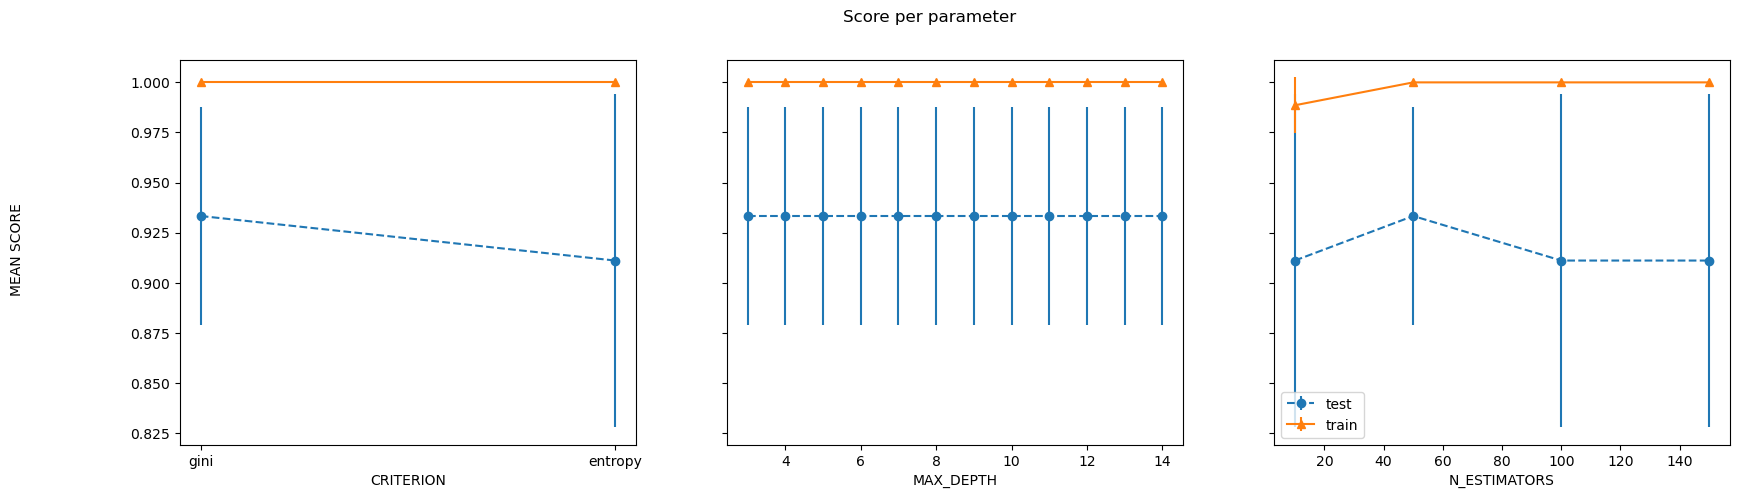

In [16]:
# plot grid search results
plot_search_results(grid_nm)

In [17]:
# Use "best params" for the decision tree
clf_nm, accuracy_train_nm, recall_train_nm, report_train_nm, accuracy_nm, recall_nm, report_nm = random_forest(X_nm, y_nm, X_val, y_val, "gini", 3, 50) 

print("Accuracy (Training set - NearMiss Under-sampling):", accuracy_train_nm)
print("\nClassification Report (Training set - NearMiss Under-sampling)")
print(report_train_nm)

print("Accuracy (Validation set - NearMiss Under-sampling):", accuracy_nm)
print("\nClassification Report (Validation set - NearMiss Under-sampling)")
print(report_nm)

Accuracy (Training set - NearMiss Under-sampling): 0.506578947368421

Classification Report (Training set - NearMiss Under-sampling)
              precision    recall  f1-score   support

           0       1.00      0.42      0.59       130
           1       0.23      1.00      0.37        22

    accuracy                           0.51       152
   macro avg       0.61      0.71      0.48       152
weighted avg       0.89      0.51      0.56       152

Accuracy (Validation set - NearMiss Under-sampling): 0.46153846153846156

Classification Report (Validation set - NearMiss Under-sampling)
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        30
           1       0.30      1.00      0.46         9

    accuracy                           0.46        39
   macro avg       0.65      0.65      0.46        39
weighted avg       0.84      0.46      0.46        39



In [18]:
# plot feature importance based on the random forest model
features_nm, scores_nm, fig= plot_important_features_RF(clf_nm, 10, X_nm, y_nm, 'NearMiss Under-sampling')
fig.write_html('plots/RF/NM_TopFeatures.html')

In [19]:
results.append({
        'best_params': best_params_nm,
        'accuracy(train)': accuracy_train_nm,
        'recall(train)': recall_train_nm,
        'accuracy(val)': accuracy_nm,
        'recall(val)': recall_nm,
        'features': features_nm,
        'socres': scores_nm,
})

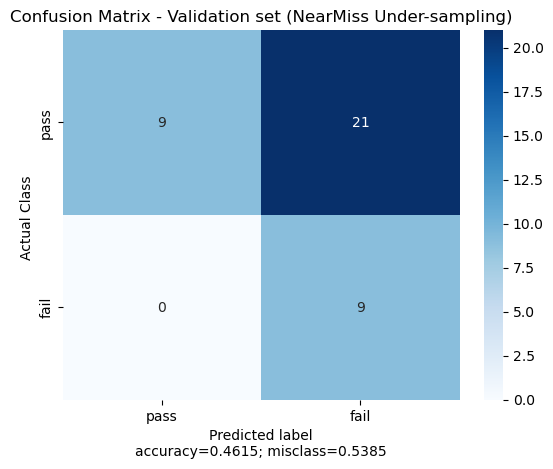

In [20]:
# plot a confusion matrix
plot_cm (clf_nm, X_val, y_val, "Validation set (NearMiss Under-sampling)")

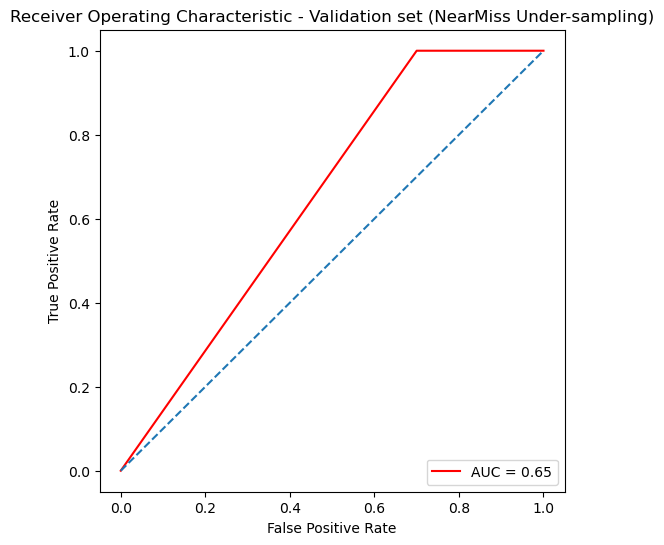

In [21]:
# plot ROC curve
plot_roc(clf_nm, X_val, y_val,"Validation set (NearMiss Under-sampling)")

## 2.2 SMOTE Over-sampling

In [22]:
# grid search
best_params_smote, scores_smote, grid_smote = rforest_grid_search(X_smote,y_smote,5)
print(best_params_smote)
scores_smote.head(3)

{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 10}


,scores,params
0,0.926923,"{'criterion': 'entropy', 'max_depth': 9, 'n_es..."
1,0.926923,"{'criterion': 'entropy', 'max_depth': 14, 'n_e..."
2,0.926923,"{'criterion': 'entropy', 'max_depth': 8, 'n_es..."


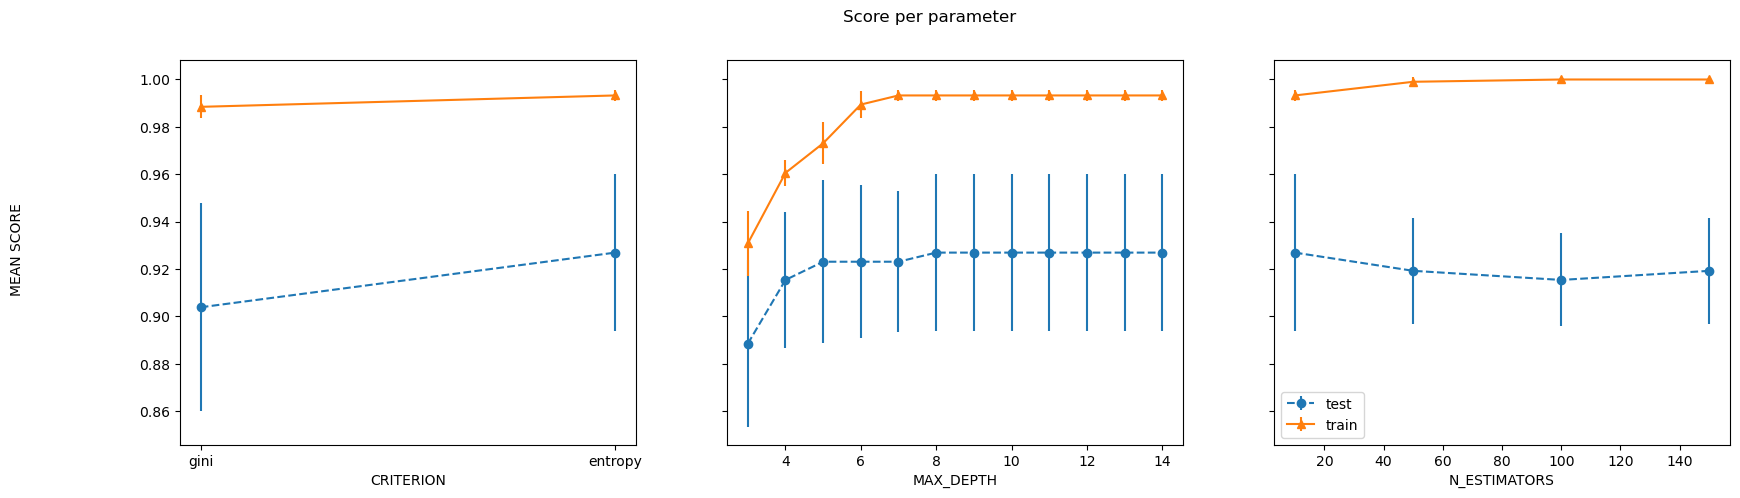

In [23]:
# plot grid search results
plot_search_results(grid_smote)

In [24]:
# Use "best params" for the random forest
clf_smote, accuracy_train_smote,recall_train_smote, report_train_smote, accuracy_smote, recall_smote, report_smote = random_forest(X_smote, y_smote, X_val, y_val, "entropy", 8, 10) 

print("Accuracy (Training set - SMOTE Over-sampling):", accuracy_train_smote)
print("\nClassification Report (Training set - SMOTE Over-sampling)")
print(report_train_smote)

print("Accuracy (Validation set - SMOTE Over-sampling):", accuracy_smote)
print("\nClassification Report (Validation set - SMOTE Over-sampling)")
print(report_smote)

Accuracy (Training set - SMOTE Over-sampling): 1.0

Classification Report (Training set - SMOTE Over-sampling)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       130
           1       1.00      1.00      1.00        22

    accuracy                           1.00       152
   macro avg       1.00      1.00      1.00       152
weighted avg       1.00      1.00      1.00       152

Accuracy (Validation set - SMOTE Over-sampling): 0.8461538461538461

Classification Report (Validation set - SMOTE Over-sampling)
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.67      0.67      0.67         9

    accuracy                           0.85        39
   macro avg       0.78      0.78      0.78        39
weighted avg       0.85      0.85      0.85        39



In [25]:
# plot feature importance based on the random forest model
features_smote, scores_smote, fig=plot_important_features_RF(clf_smote, 10, X_smote, y_smote, 'SMOTE Over-sampling') 
fig.write_html('plots/RF/SMOTE_OS_TopFeatures.html')

In [26]:
results.append({
        'best_params': best_params_smote,
        'accuracy(train)': accuracy_train_smote,
        'recall(train)': recall_train_smote,
        'accuracy(val)': accuracy_smote,
        'recall(val)': recall_smote,
        'features': features_smote,
        'socres': scores_smote,
})

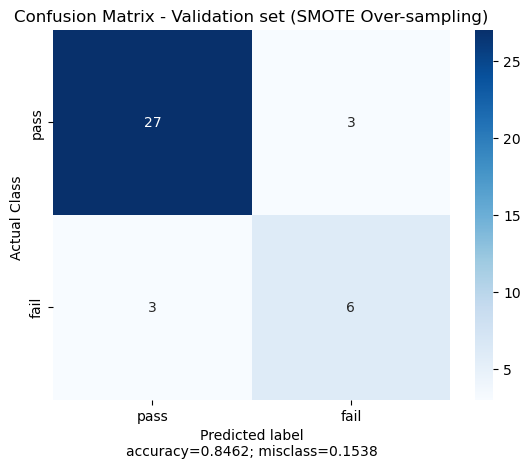

In [27]:
# plot a confusion matrix
plot_cm(clf_smote, X_val, y_val, "Validation set (SMOTE Over-sampling)")

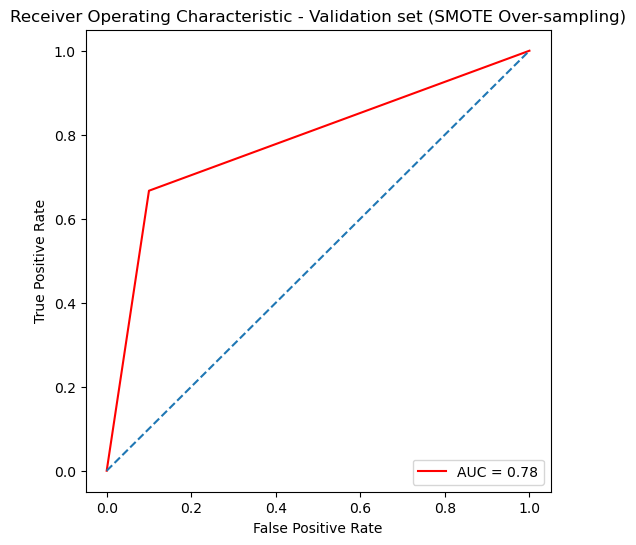

In [28]:
# plot ROC curve
plot_roc(clf_smote, X_val, y_val, "Validation set (SMOTE Over-sampling)")

## 2.3. SMOTEENN

In [29]:
# grid search
best_params_smoteenn, scores_smoteenn, grid_smoteenn = rforest_grid_search(X_smoteenn,y_smoteenn,5)
print(best_params_smoteenn)
scores_smoteenn.head(3)

{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100}


,scores,params
0,0.965122,"{'criterion': 'entropy', 'max_depth': 3, 'n_es..."
1,0.965122,"{'criterion': 'entropy', 'max_depth': 13, 'n_e..."
2,0.965122,"{'criterion': 'entropy', 'max_depth': 9, 'n_es..."


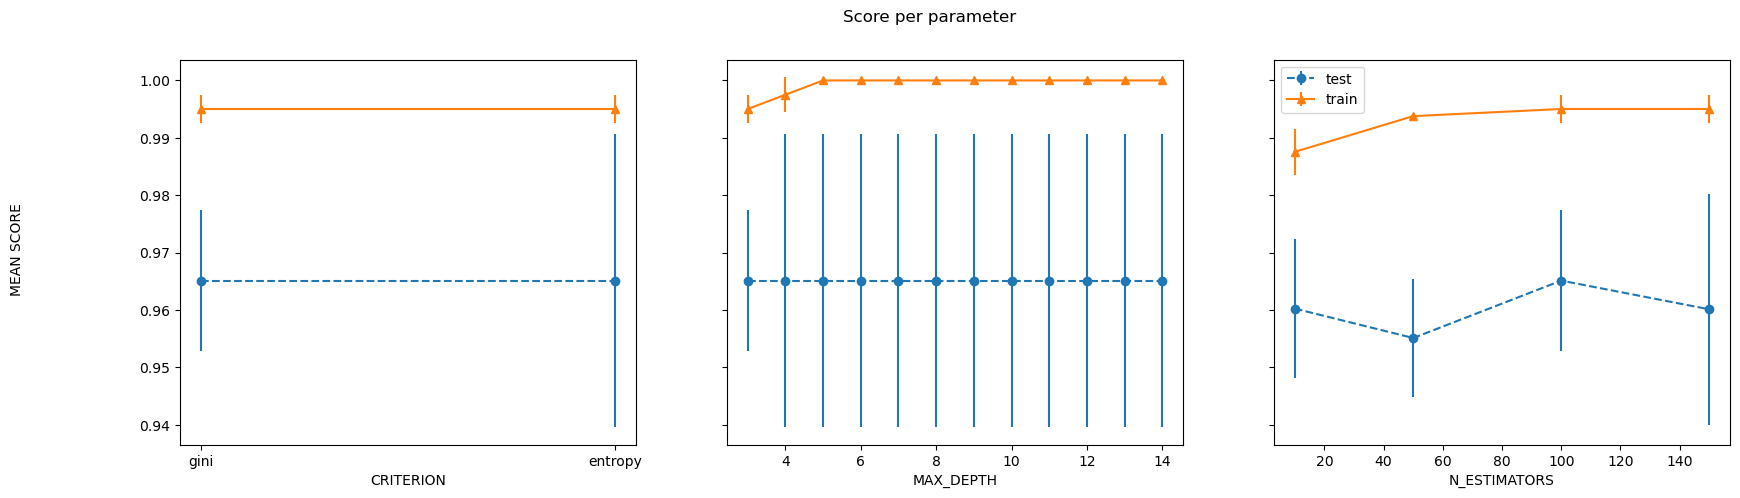

In [30]:
# plot grid search results
plot_search_results(grid_smoteenn)

In [31]:
# Use "best params" for the random forest
clf_smoteenn, accuracy_train_smoteenn,recall_train_smoteenn, report_train_smoteenn, accuracy_smoteenn,recall_smoteenn, report_smoteenn = random_forest(X_smoteenn, y_smoteenn, X_val, y_val, "gini", 3, 100) 

print("Accuracy (Training set - SMOTEENN):", accuracy_train_smoteenn)
print("\nClassification Report (Training set - SMOTEENN)")
print(report_train_smoteenn)

print("Accuracy (Validation set - SMOTEENN:", accuracy_smoteenn)
print("\nClassification Report (Validation set - SMOTEENN)")
print(report_smoteenn)

Accuracy (Training set - SMOTEENN): 0.9013157894736842

Classification Report (Training set - SMOTEENN)
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       130
           1       0.61      0.91      0.73        22

    accuracy                           0.90       152
   macro avg       0.79      0.90      0.83       152
weighted avg       0.93      0.90      0.91       152

Accuracy (Validation set - SMOTEENN: 0.8461538461538461

Classification Report (Validation set - SMOTEENN)
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.62      0.89      0.73         9

    accuracy                           0.85        39
   macro avg       0.79      0.86      0.81        39
weighted avg       0.88      0.85      0.85        39



In [32]:
# plot feature importance based on the random forest model
features_smoteenn, scores_smoteenn, fig = plot_important_features_RF(clf_smoteenn, 10, X_smoteenn, y_smoteenn, 'SMOTEENN')
fig.write_html('plots/RF/SMOTEENN_TopFeatures.html')

In [33]:
results.append({
        'best_params': best_params_smoteenn,
        'accuracy(train)': accuracy_train_smoteenn,
        'recall(train)': recall_train_smoteenn,       
        'accuracy(val)': accuracy_smoteenn,
        'recall(val)': recall_smoteenn,
        'features': features_smoteenn,
        'socres': scores_smoteenn,
})

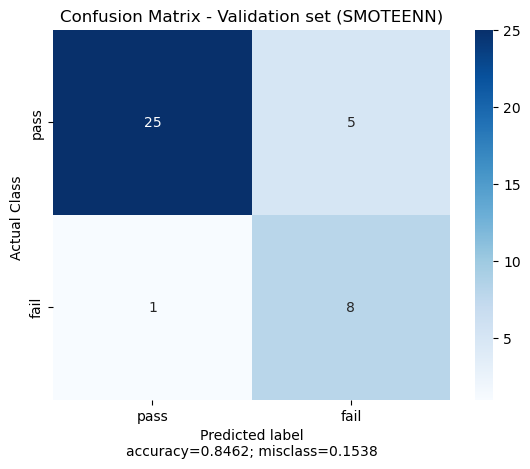

In [34]:
# plot a confusion matrix
plot_cm(clf_smoteenn, X_val, y_val, "Validation set (SMOTEENN)")

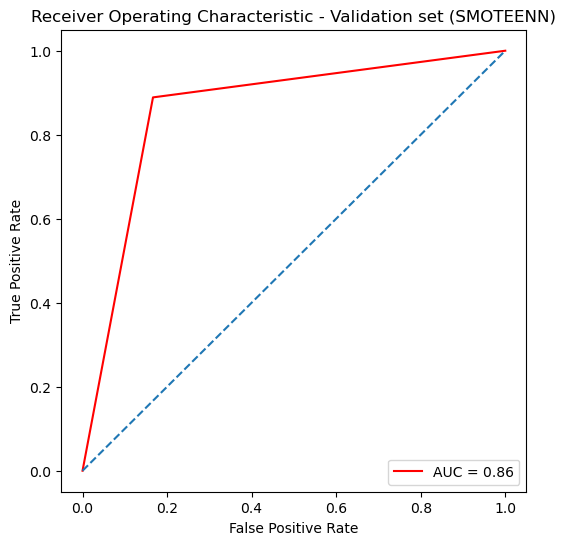

In [35]:
# plot ROC curve
plot_roc(clf_smoteenn, X_val, y_val, "Validation set (SMOTEENN)")

## 2.4. SMOTETomek

In [36]:
# grid search
best_params_smotetomek, scores_smotetomek, grid_smotetomek = rforest_grid_search(X_smotetomek,y_smotetomek,5)
print(best_params_smotetomek)
scores_smotetomek.head(3)

{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 10}


,scores,params
0,0.918778,"{'criterion': 'entropy', 'max_depth': 9, 'n_es..."
1,0.918778,"{'criterion': 'entropy', 'max_depth': 14, 'n_e..."
2,0.918778,"{'criterion': 'entropy', 'max_depth': 10, 'n_e..."


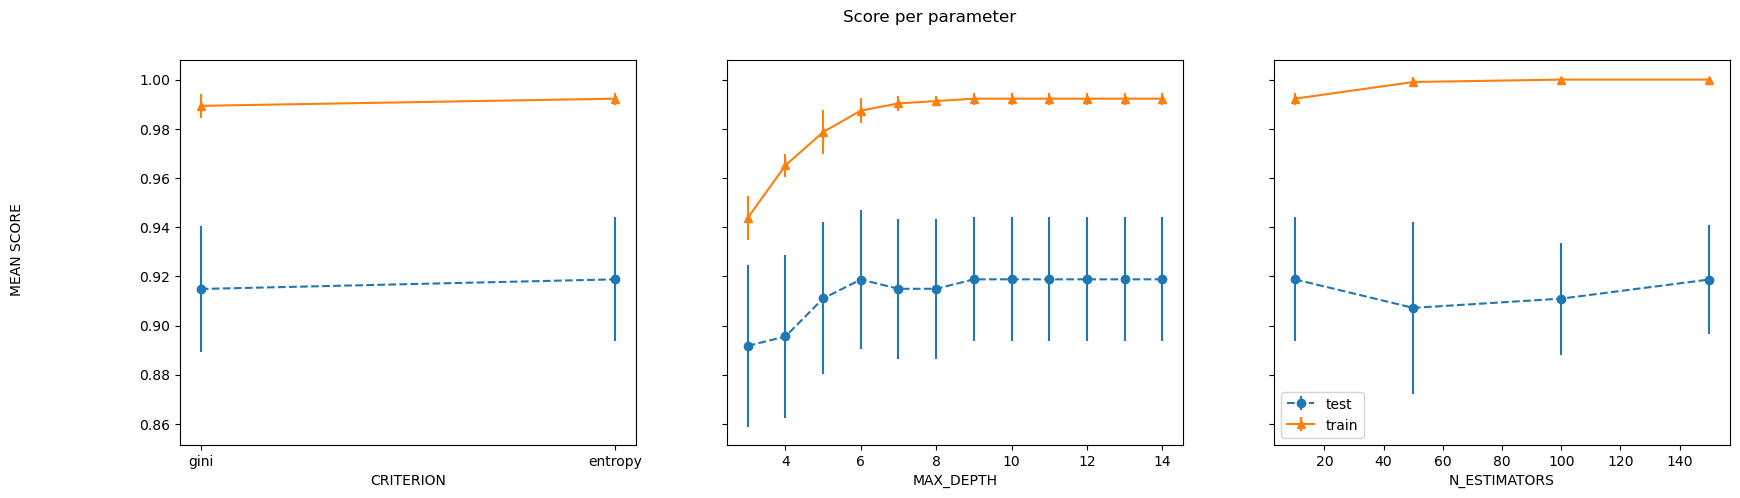

In [37]:
# plot grid search results
plot_search_results(grid_smotetomek)

In [38]:
# Use "best params" for the random forest
clf_smotetomek, accuracy_train_smotetomek,recall_train_smotetomek, report_train_smotetomek, accuracy_smotetomek, recall_smotetomek, report_smotetomek = random_forest(X_smotetomek, y_smotetomek, X_val, y_val, "entropy", 9, 10) 

print("Accuracy (Training set - SMOTETomek):", accuracy_train_smotetomek)
print("\nClassification Report (Training set - SMOTETomek")
print(report_train_smotetomek)

print("Accuracy (Validation set - SMOTETomek:", accuracy_smotetomek)
print("\nClassification Report (Validation set - SMOTETomek)")
print(report_smotetomek)

Accuracy (Training set - SMOTETomek): 1.0

Classification Report (Training set - SMOTETomek
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       130
           1       1.00      1.00      1.00        22

    accuracy                           1.00       152
   macro avg       1.00      1.00      1.00       152
weighted avg       1.00      1.00      1.00       152

Accuracy (Validation set - SMOTETomek: 0.8717948717948718

Classification Report (Validation set - SMOTETomek)
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        30
           1       0.70      0.78      0.74         9

    accuracy                           0.87        39
   macro avg       0.82      0.84      0.83        39
weighted avg       0.88      0.87      0.87        39



In [39]:
# plot feature importance based on the random forests model
features_smotetomek, scores_smotetomek, fig = plot_important_features_RF(clf_smotetomek, 10, X_smotetomek, y_smotetomek, 'SMOTETomek')
fig.write_html('plots/RF/SMOTETomek_TopFeatures.html')

In [40]:
results.append({
        'best_params': best_params_smotetomek,
        'accuracy(train)': accuracy_train_smotetomek,
        'recall(train)': recall_train_smotetomek,
        'accuracy(val)': accuracy_smotetomek,
        'recall(val)': recall_smotetomek,
        'features': features_smotetomek,
        'socres': scores_smotetomek,
})

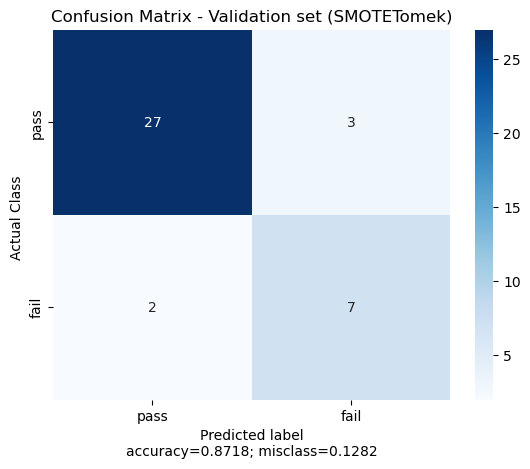

In [41]:
# plot a confusion matrix
plot_cm(clf_smotetomek, X_val, y_val, "Validation set (SMOTETomek)")

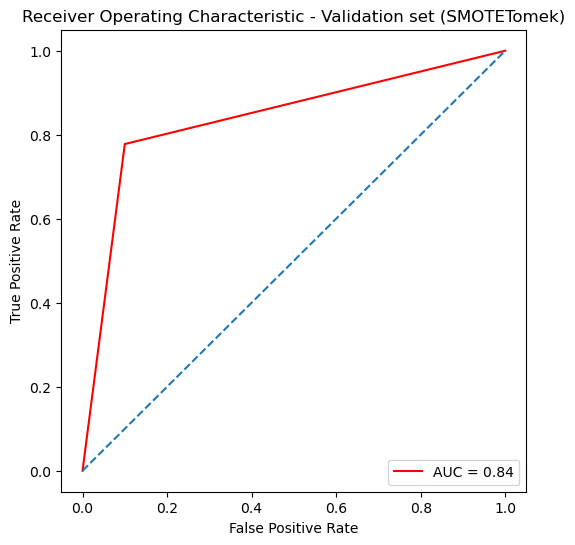

In [42]:
# plot ROC curve
plot_roc(clf_smotetomek, X_val, y_val, "Validation set (SMOTETomek)")

In [43]:
summary = pd.DataFrame(results)
summary

,best_params,accuracy(train),recall(train),accuracy(val),recall(val),features,socres
0,"{'criterion': 'gini', 'max_depth': 3, 'n_estim...",0.506579,0.711538,0.461538,0.650000,"[fa1122, fa1296, fa1155, fa1189, fa1000, fa122...","[0.087, 0.062, 0.052, 0.048, 0.048, 0.043, 0.0..."
1,"{'criterion': 'entropy', 'max_depth': 8, 'n_es...",1.000000,1.000000,0.846154,0.783333,"[fa1455, fa840, fa1000, fa1542, fa1090, fa1296...","[0.078, 0.063, 0.063, 0.062, 0.058, 0.044, 0.0..."
2,"{'criterion': 'gini', 'max_depth': 3, 'n_estim...",0.901316,0.904545,0.846154,0.861111,"[fa1189, fa771, fa1155, fa971, fa1090, fa793, ...","[0.083, 0.075, 0.069, 0.064, 0.058, 0.055, 0.0..."
3,"{'criterion': 'entropy', 'max_depth': 9, 'n_es...",1.000000,1.000000,0.871795,0.838889,"[fa1090, fa1296, fa971, fa1887, fa1000, fa1224...","[0.1, 0.088, 0.063, 0.062, 0.052, 0.043, 0.04,..."


# 3. Summary

> **Random Forests**
> <table>
>   <thead>
>     <tr>
>       <th>Dataset</th>
>       <th>Hyperparameters</th>
>       <th>Top 3 features</th>
>       <th>Feature importances</th>
>       <th>Accuracy on the validation set</th>
>       <th>Recall on the validation set</th>
>       <th>F1 on the validation set</th>
>       <th>AUC on the validation set</th>
>     </tr>
>   </thead>
>   <tbody>
>     <tr>
>       <td>NearMiss Under-sampling</td>
>       <td>{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 50}</td>
>       <td>[fa1122, fa1296, fa1155] </td>
>       <td>[0.087, 0.062, 0.052]</td>
>       <td>0.46</td>
>       <td>0.65</td>
>       <td>0.46</td>
>       <td>0.65</td>
>     </tr>
>     <tr>
>       <td>SMOTE Over-sampling</td>
>       <td>{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 10}</td>
>       <td>[fa1455, fa840, fa1000] </td>
>       <td>[0.078, 0.063, 0.063]</td>
>       <td>0.85</td>
>       <td>0.78</td>
>       <td>0.78</td>
>       <td>0.78</td>
>     </tr>
>     <tr>
>       <td>SMOTEENN</td>
>       <td>{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100}</td>
>       <td>[fa1189, fa771, fa1155] </td>
>       <td>[0.083, 0.075, 0.069]</td>
>       <td>0.85</td>
>       <td>0.86</td>
>       <td>0.81</td>
>       <td>0.86</td>
>     </tr>
>     <tr>
>       <td>SMOTETomek</td>
>       <td>{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 10}</td>
>       <td>[fa1090, fa1296, fa971] </td>
>       <td>[0.100, 0.088, 0.063]</td>
>       <td>0.87</td>
>       <td>0.84</td>
>       <td>0.83</td>
>       <td>0.84</td>
>     </tr>
>   </tbody>
> </table>
> <br>

# 4. Test the best model on the test set.

> Comment: <br>
> - I select the best model based on the highest recall. <br>
> - SMOTEENN provides the highse recall score on the validation set. <br>

In [44]:
# test the best model on the test set
# predict test data
y_pred_train = clf_smoteenn.predict(X_train)
y_pred_test = clf_smoteenn.predict(X_test)
# accuracy and classification report
accuracy_train = accuracy_score(y_train, y_pred_train)
report_train = classification_report(y_train, y_pred_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)

print("Accuracy (Training set - SMOTEENN:", accuracy_train)
print("\nClassification Report (Training set - SMOTEENN)")
print(report_train)

print("Accuracy (Test set - SMOTEENN:", accuracy_test)
print("\nClassification Report (Test set - SMOTEENN)")
print(report_test)

Accuracy (Training set - SMOTEENN: 0.9013157894736842

Classification Report (Training set - SMOTEENN)
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       130
           1       0.61      0.91      0.73        22

    accuracy                           0.90       152
   macro avg       0.79      0.90      0.83       152
weighted avg       0.93      0.90      0.91       152

Accuracy (Test set - SMOTEENN: 0.8333333333333334

Classification Report (Test set - SMOTEENN)
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        41
           1       0.47      1.00      0.64         7

    accuracy                           0.83        48
   macro avg       0.73      0.90      0.76        48
weighted avg       0.92      0.83      0.85        48



# 5. SHAP

In [45]:
def shap_forece_plot(model, X_test, y_test, choosen_instance, class_idx=1):
    ## Store model prediction and ground truth label
    pred = model.predict(X_test.loc[[choosen_instance]])
    true_label = y_test.iloc[choosen_instance].to_numpy()
    
    ## Assess accuracy of prediction
    if true_label[0] == pred[0]:
        accurate = 'Correct!'
    else:
        accurate = 'Incorrect' 
    
    ## Print output that checks model's prediction against true label
    print('***'*12)
    # Print ground truth label for row at index
    print(f'Ground Truth Label: {true_label}')
    print()
    # Print model prediction for row at index
    print(f'Model Prediction:  {pred} -- {accurate}')
    print('***'*12)
    print()

    # Create Tree Explainer object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    # Calculate Shap values for the choosen instance
    shap_values = explainer.shap_values(X_test.loc[[choosen_instance]])
    shap.initjs()
    # Force plot for class 0 or 1
    force_plot = shap.force_plot(explainer.expected_value[class_idx], shap_values[class_idx], X_test.loc[[choosen_instance]])
    return force_plot


def shap_decision_plot(model, X_test, choosen_instance,class_idx=1):
    # Choose a random row number to analyze 
    row_num = choosen_instance
    row_data = X_test.iloc[row_num] 

    # Calculate shap values using the TreeExplainer 
    explainer  = shap.TreeExplainer(model) 
    shap_values  = explainer.shap_values(row_data) 
    # Create a decision plot 
    decision_plot = shap.decision_plot(explainer.expected_value[class_idx], shap_values[class_idx], X_test.columns)
    return decision_plot

## 5.1. Explain the best model

> Comment: <br>
> - I use SHAP to explain the best model

### 5.1.1. Interpretation for a single prediction

In [46]:
# calculate shap value for one instance
shap_forece_plot(clf_smoteenn, X_test, y_test, 5) # select instance 5

************************************
Ground Truth Label: [0]

Model Prediction:  [0] -- Correct!
************************************



In [47]:
# calculate shap value for one instance
shap_forece_plot(clf_smoteenn, X_test, y_test, 18) # select instance 18

************************************
Ground Truth Label: [1]

Model Prediction:  [1] -- Correct!
************************************



> Comment: <br>
> * SHAP values to explain the predicted cancer probabilities of two individuals. The baseline – the average predicted probability – is 0.5804. <br>
> * I use class 1 as the baseline, so 0.5804 is the probability of having hearing loss.
> * Oberservation 5 has a very low predicted risk of hearing loss. The predicted risk is around 0.05. fa1155 = 0.8271, fa1189 = 0.8246, and fa771 = 0.5676 help to reduce the risk.<br>
> * Oberservation 18 has a very high predicted risk of hearing loss. The predicted risk is around 0.97. fa1189 = 0.1014 and fa771 = 0.2975 imply the high predicted risk.

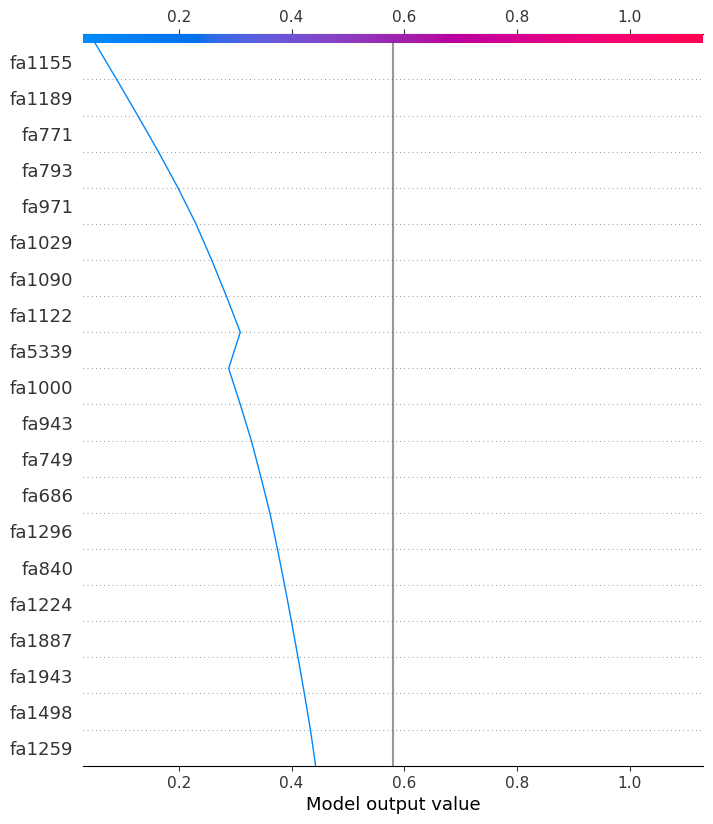

In [48]:
# decision plot for instance 5
shap_decision_plot(clf_smoteenn, X_test, 5)

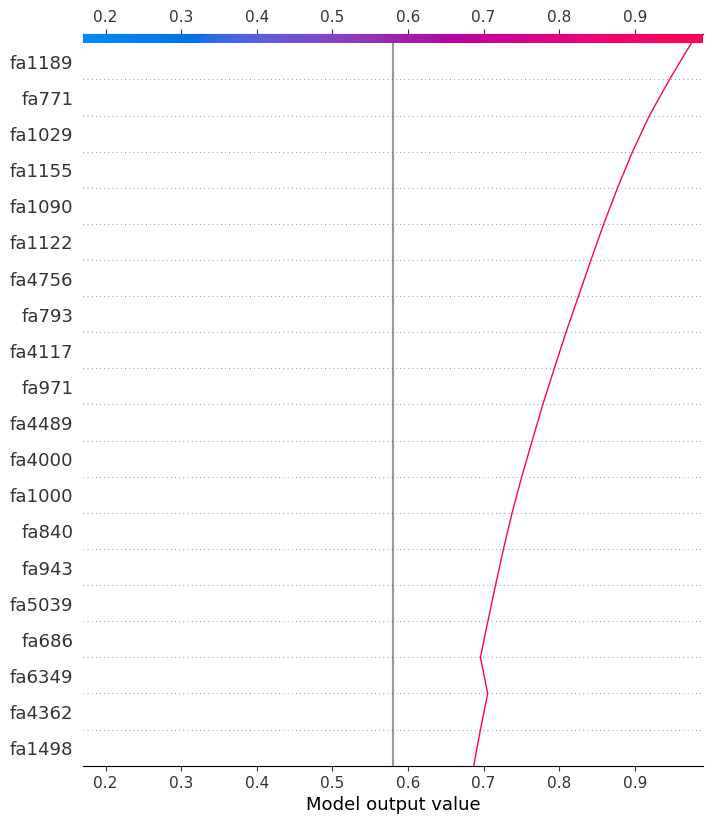

In [49]:
# decision plot for instance 18
shap_decision_plot(clf_smoteenn, X_test, 18)

### 5.1.2. Global interpretation

In [50]:
def shap_summary_plot_bar(model, X_test):
    ''' 
    Summary plot of feature importance
    '''
    # Create Tree Explainer object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    # Calculate Shap values for X_test
    shap_values = explainer.shap_values(X_test)
    shap.initjs()
    summary_plot = shap.summary_plot(shap_values, X_test)
    return summary_plot


def shap_summary_plot(model, X_test, class_index=1):
    ''' 
    Summary plot of specific classification results
    '''
    # Create Tree Explainer object that can calculate shap values
    explainer = shap.TreeExplainer(model)
    # Calculate Shap values for the choosen instance
    shap_values = explainer.shap_values(X_test)
    shap.initjs()
    # get the SHAP values for the prediction of class 0 or 1, which depends on 'class_index'
    summary_plot = shap.summary_plot(shap_values[class_index], X_test)
    return summary_plot

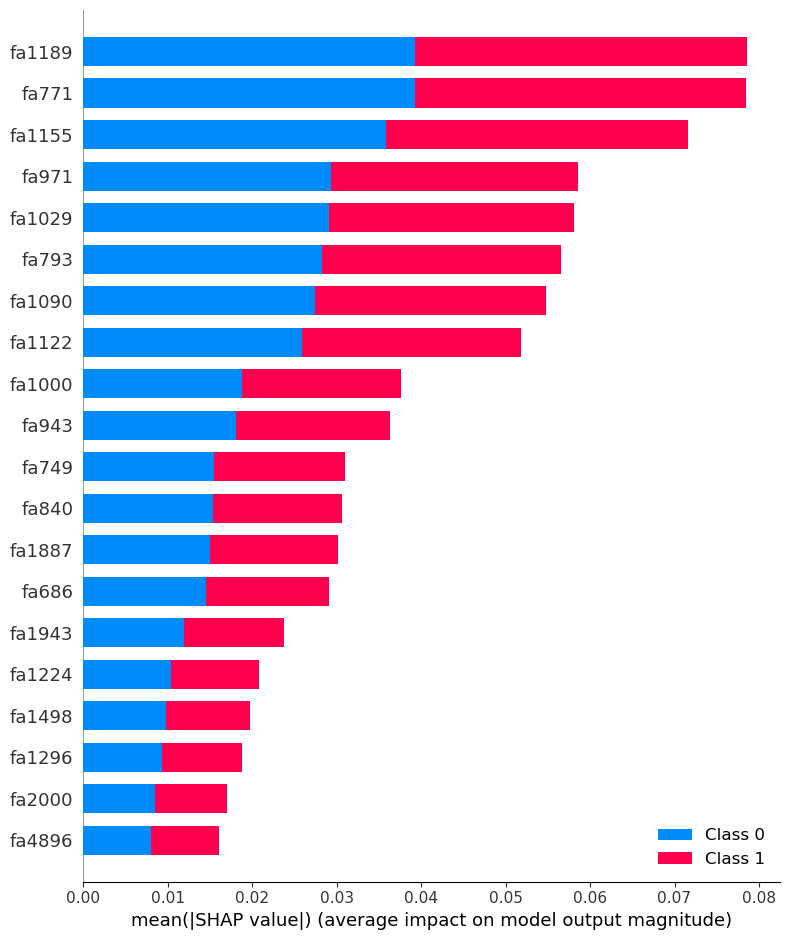

In [51]:
# see the summary plot 
shap_summary_plot_bar(clf_smoteenn,  X_test) 

> Comment:<br>
> - It shows a list of important characteristics, from most important to least important (top to bottom). <br>
> - All features seem to contribute equally to both classes diagnosed as fail (class = 1) or pass (class = 0), since basically both occupy 50% of the rectangle. <br>
> - According to the model, fa1189 is the feature that contributes the most to the prediction. fa771 is the second most contributing feature. <br>

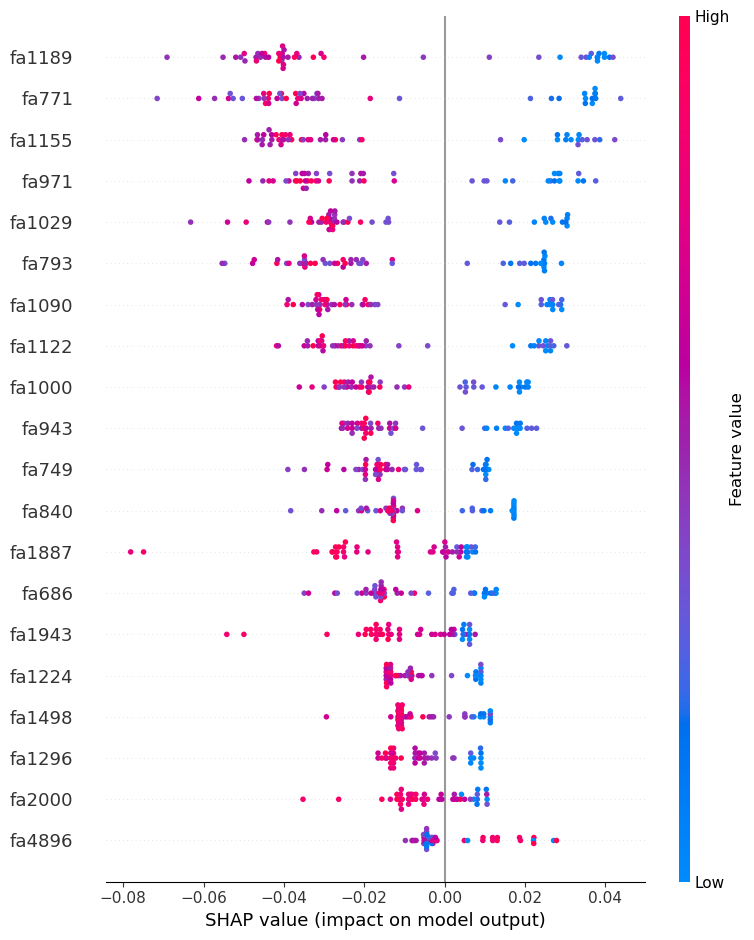

In [52]:
# Summary Plot Deep-Dive on class 1
shap_summary_plot(clf_smoteenn, X_test,1)

> Comment: <br>
> For classification problems, each label has a SHAP value. In our example, I use a prediction of 1 (Fail) to display a summary of that class of results. The representation of the figure is as follows: <br>
> - The importance and ranking of features is the same as for summary plots, the higher the ranking, the higher the importance. <br>
> - Each point in the graph represents a shap value of a single data instance. <br>
> - The color indicates whether the feature has a high value (red) or a low value (blue).<br>
> - The x-axis represents the positive or negative contribution to the predicted output. 
> 
> When we apply these analyses to the features, we get the following conclusions:<br>
> - For fa1189: we see that most of the low values (blue dots) contribute positively to the predicted output (positive on the x-axis). In other words, if the fa1189 of a single data instance is low, its chances of getting a 1 result (fail hearing tests) are greatly increased, while high values (red dots) will decrease (negative X-axis values) the probability of being diagnosed with hearing loss. <br>
> - On the other hand, the model seems to be a little confusing at fa4896, as we can observe data points with both high and low values on each side of the vertical line (X-axis = 0). <br>
> 
> Since the fa4896 feature seems confusing for analysis, we can use the dependence plot below to get more fine-grained information.

### 5.1.3. Dependence Plots

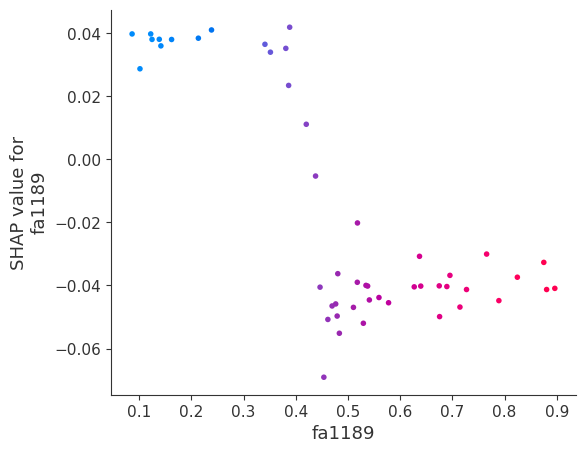

In [53]:
# Dependence Plot on fa1189 feature
explainer = shap.TreeExplainer(clf_smoteenn)
shap_values = explainer.shap_values(X_test)
shap.dependence_plot('fa1189', shap_values[1], X_test, interaction_index="fa1189")

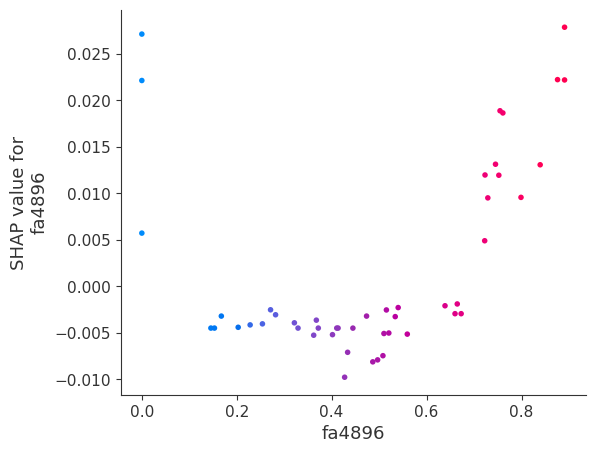

In [54]:
# Dependence Plot on fa4896 feature
explainer = shap.TreeExplainer(clf_smoteenn)
shap_values = explainer.shap_values(X_test)
shap.dependence_plot('fa4896', shap_values[1], X_test, interaction_index="fa4896")

> Comment:<br>
> - From the dependence plot we can clearly see that children with fa1189 below 0.4 have a higher risk of being diagnosed with hearing loss, while children with fa1189 higher than 0.4 have a higher probability of passing the hearing tests. <br>
> - When fa4896 is very high or very low, children are at higher risk of being diagnosed with hearing loss. But when fa4896 is in the range of about 0.1 to 0.7, the probability of children passing the hearing test is higher.

> 

# 6. Focus on selected features 

In [55]:
def plot_lines(frequencies, df_plot):
    '''
    Plot the selected frequencies on the mean absorbance line curves with 95% CI
    '''
    # I also create a grouped version, with calculated mean and standard deviation.
    df_pass = df_plot[df_plot['PoF']=='Pass']
    df_fail = df_plot[df_plot['PoF']=='Fail'] 

    # pass group
    df_grouped_pass = (
        df_pass[['frequencies', 'absorbance']].groupby(['frequencies'], sort=False)
        .agg(['mean', 'std', 'count'])
    )
    df_grouped_pass = df_grouped_pass.droplevel(axis=1, level=0).reset_index()
    # Calculate a confidence interval as well.
    df_grouped_pass['ci'] = 1.96 * df_grouped_pass['std'] / np.sqrt(df_grouped_pass['count'])
    df_grouped_pass['ci_lower'] = df_grouped_pass['mean'] - df_grouped_pass['ci']
    df_grouped_pass['ci_upper'] = df_grouped_pass['mean'] + df_grouped_pass['ci']

    # fail group
    df_grouped_fail = (
        df_fail[['frequencies', 'absorbance']].groupby(['frequencies'], sort=False)
        .agg(['mean', 'std', 'count'])
    )
    df_grouped_fail = df_grouped_fail.droplevel(axis=1, level=0).reset_index()
    # Calculate a confidence interval as well.
    df_grouped_fail['ci'] = 1.96 * df_grouped_fail['std'] / np.sqrt(df_grouped_fail['count'])
    df_grouped_fail['ci_lower'] = df_grouped_fail['mean'] - df_grouped_fail['ci']
    df_grouped_fail['ci_upper'] = df_grouped_fail['mean'] + df_grouped_fail['ci']

    # plot the line graphs
    fig = go.Figure([
        # fail group
        go.Scatter(
            name='Fail',
            x=df_grouped_fail['frequencies'],
            y=round(df_grouped_fail['mean'], 2),
            mode='lines',
            line=dict(color='rgb(23, 190, 207)'),
        ),
        go.Scatter(
            name='95% CI Upper',
            x=df_grouped_fail['frequencies'],
            y=round(df_grouped_fail['ci_upper'], 2),
            mode='lines',
            marker=dict(color='#444'),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='95% CI Lower',
            x=df_grouped_fail['frequencies'],
            y=round(df_grouped_fail['ci_lower'], 2),
            marker=dict(color='#444'),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 100, 200, 0.2)',
            fill='tonexty',
            showlegend=False
        ),
        # pass group
        go.Scatter(
            name='Pass',
            x=df_grouped_pass['frequencies'],
            y=round(df_grouped_pass['mean'], 2),
            mode='lines',
            line=dict(color='rgb(255, 127, 14)'),
        ),
        go.Scatter(
            name='95% CI Upper',
            x=df_grouped_pass['frequencies'],
            y=round(df_grouped_pass['ci_upper'], 2),
            mode='lines',
            marker=dict(color='#444'),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='95% CI Lower',
            x=df_grouped_pass['frequencies'],
            y=round(df_grouped_pass['ci_lower'], 2),
            marker=dict(color='#444'),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(200, 100, 68, 0.2)',
            fill='tonexty',
            showlegend=False
        ),
    ])

    # Add vertical lines
    for i in frequencies:
        fig.add_vline(x=i, line_width=1, line_dash="dash", line_color="red")

    fig.update_layout(
        xaxis_title='Frequencies',
        yaxis_title='Avg absorbance',
        title='Avg absorbance by frequency (Random forest)',
        hovermode='x'
    )
    fig.update_yaxes(rangemode='tozero')
    fig.show()
    return fig

In [56]:
# Merge back to the original data
X_train_org = pd.read_csv('X_train.csv')
y_train_org = pd.read_csv('y_train.csv')
X_val_org = pd.read_csv('X_val.csv')
y_val_org = pd.read_csv('y_val.csv')
X_test_org = pd.read_csv('X_test.csv')
y_test_org = pd.read_csv('y_test.csv')

# Select frequenies
X_train_org = X_train_org.filter(regex='fa',axis=1)
X_val_org = X_val_org.filter(regex='fa',axis=1)
X_test_org = X_test_org.filter(regex='fa', axis=1)

X_frames = [X_train_org, X_val_org, X_test_org]
y_frames = [y_train_org, y_val_org, y_test_org]
X_original = pd.concat(X_frames)
y_original = pd.concat(y_frames)

df = pd.concat([X_original, y_original], axis=1)
print("df shape", df.shape)

df shape (239, 108)


In [57]:
# prepare the dataframe for plotting line graphs
df_plot=pd.melt(df,'OverallPoF')
df_plot['PoF'] = np.where(df_plot['OverallPoF']==0, 'Pass', 'Fail')
df_plot.rename({'variable':'frequencies', 'value':'absorbance'}, axis=1, inplace=True)

In [58]:
selected_index = 2 # SMOTEENN
selected_freq = summary.iloc[selected_index].features
print(selected_freq)

['fa1189', 'fa771', 'fa1155', 'fa971', 'fa1090', 'fa793', 'fa1029', 'fa1122', 'fa1000', 'fa943']


In [59]:
fig = plot_lines(selected_freq, df_plot)
fig.write_html('plots/RF/SelectedFeatures.html')

# 7. Recursive Feature Elimination (RFE) with Cross-Validation based on the best RF model

In [60]:
model = clf_smoteenn

rfecv=RFECV(estimator=model,step=1,cv=10,scoring='recall')
rfecv.fit(X_train,y_train.to_numpy().ravel())

print("Optimal number of features : %d" % rfecv.n_features_)
X_rfe = X_train.columns[rfecv.get_support()] 
print("Selected features:", list(X_rfe))

Optimal number of features : 10
Selected features: ['fa1090', 'fa1122', 'fa1155', 'fa1224', 'fa1259', 'fa1296', 'fa1455', 'fa1542', 'fa1633', 'fa4117']


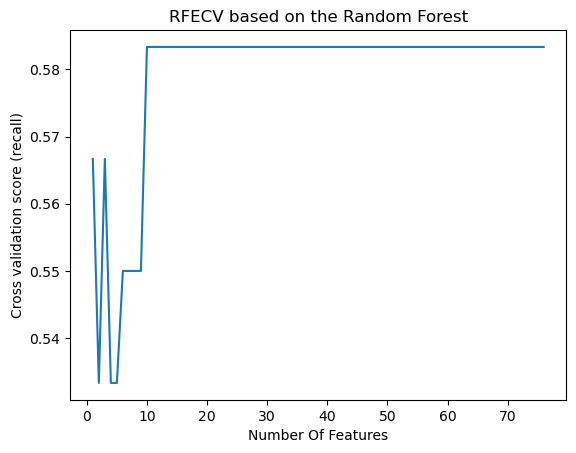

In [61]:
#We can see that the best number of features is 10
plt.title("RFECV based on the Random Forest")
plt.xlabel("Number Of Features")
plt.ylabel("Cross validation score (recall)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

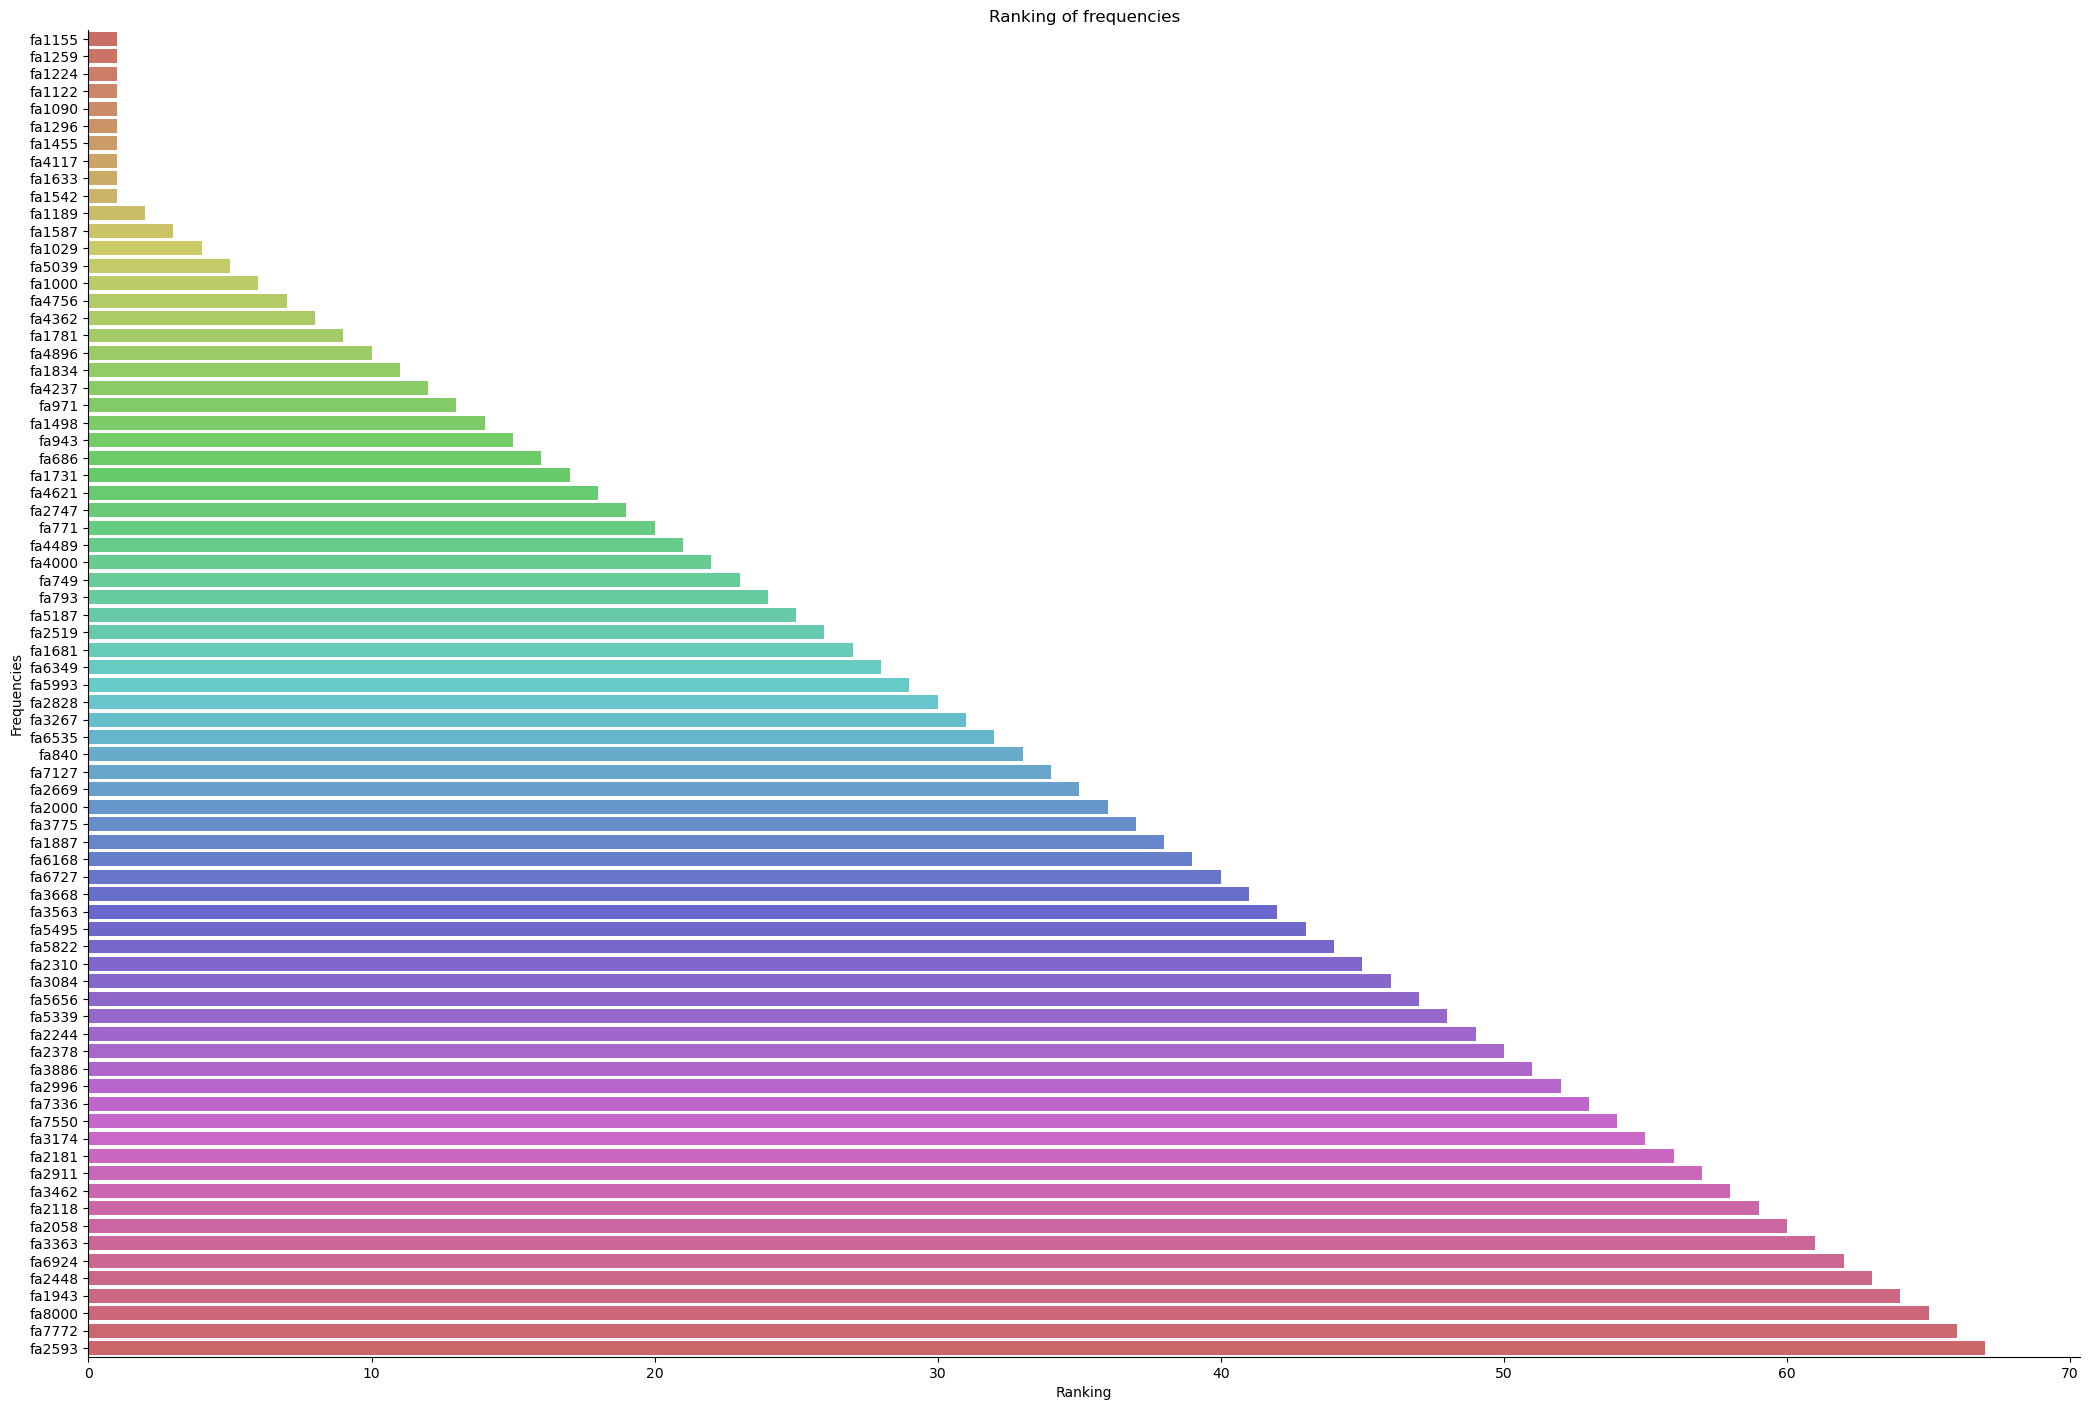

In [62]:
# plot the ranking of the features
ranking = list(rfecv.ranking_)
colnames = list(X_train.columns)
rankplot = pd.DataFrame({"Frequencies":colnames, "Ranking":ranking})
# Sort the dataframe
rankplot = rankplot.sort_values('Ranking', ascending=True)
sns.catplot(x="Ranking", y="Frequencies", data = rankplot, kind="bar", height=14, aspect=1.5, palette="hls").set(title='Ranking of frequencies')

In [63]:
# use rfecv model to predict values
y_pred_train = rfecv.predict(X_train)
y_pred_test = rfecv.predict(X_test)
# accuracy and classification report
accuracy_train = accuracy_score(y_train, y_pred_train)
report_train = classification_report(y_train, y_pred_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)

print("Accuracy (Training set - SMOTEENN:", accuracy_train)
print("\nClassification Report (Training set - SMOTEENN)")
print(report_train)

print("Accuracy (Test set - SMOTEENN:", accuracy_test)
print("\nClassification Report (Test set - SMOTEENN)")
print(report_test)

Accuracy (Training set - SMOTEENN: 0.9671052631578947

Classification Report (Training set - SMOTEENN)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       130
           1       1.00      0.77      0.87        22

    accuracy                           0.97       152
   macro avg       0.98      0.89      0.93       152
weighted avg       0.97      0.97      0.97       152

Accuracy (Test set - SMOTEENN: 0.9375

Classification Report (Test set - SMOTEENN)
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        41
           1       0.70      1.00      0.82         7

    accuracy                           0.94        48
   macro avg       0.85      0.96      0.89        48
weighted avg       0.96      0.94      0.94        48



In [64]:
#!jupyter nbconvert --to html 02-RandomForests_main.ipynb